# Transfer QAOA params between graphs


In [1]:
import qtensor
import networkx as nx
import numpy as np

/home/danlkv/.local/bin/lib/python3.8/site-packages/numba-0.52.0rc2-py3.8-linux-x86_64.egg/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats
%matplotlib inline
__plot_height = 2.719
matplotlib.rcParams['figure.figsize'] = (1.618*__plot_height, __plot_height)
set_matplotlib_formats('svg')

In [4]:
p = 4
gamma, beta = np.linspace(0, 1, p), np.linspace(1, 0, p)
gamma /= 2
beta /= 2

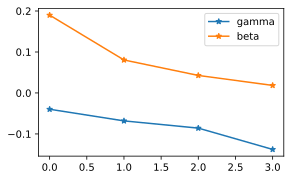

In [5]:
import json
parameters_nu3 = json.load(open('../parameters_nu3.json'))

def plot_gamma_beta(gamma, beta):
    plt.plot(gamma,'*-',  label='gamma')
    plt.plot(beta, '*-', label='beta')
    plt.legend()
    
def get_parameters_nu3(p):
    """
    Args:
        p(int)
    Returns:
        gamma, beta from 0 to 1
    """
    p_ =  parameters_nu3[str(p)]
    # yes, they are mixed up on purpose, mistake in the file
    return np.array(p_['beta'])/np.pi, -np.array(p_['gamma'])/np.pi

gamma, beta = get_parameters_nu3(p)
plot_gamma_beta(gamma, beta)

## Opitimize bethe lattice

In [6]:
B = qtensor.toolbox.bethe_graph(p=p, degree=3)

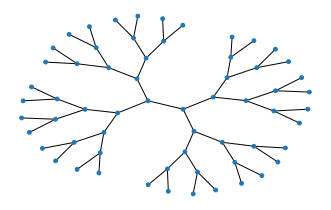

In [7]:
if p<5:
    nx.draw_kamada_kawai(B, node_size=15)

In [8]:
from qtensor import parameter_optimization as popt
import torch

In [75]:
loss_history, params_history = popt.qaoa_maxcut_torch(B, gamma, beta,
                                                      ordering_algo='tamaki_20',
                                                      edge=(0, 1),
                                                      Opt=torch.optim.Adam,
                                                      opt_kwargs=dict(lr=0.006),
                                                      steps=60)

Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=None, width=None
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8
Time=7481, width=8


Treewidth 8


Time=7481, width=8
Exception: Timeout. Stoppnig tamaki


Best solution: -0.6334599788432105
Best params: [array([-0.06480536, -0.12393928, -0.15563141, -0.18205736]), array([0.18911757, 0.14025331, 0.09947232, 0.05192453])]


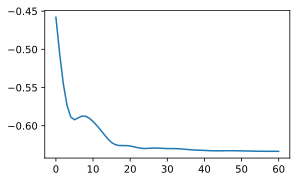

In [76]:
plt.plot(loss_history)
print('Best solution:', np.min(loss_history))
best_ix = np.argmin(loss_history)
best_params = params_history[best_ix]
print('Best params:', best_params)

In [77]:
np.concatenate(best_params)*np.pi

array([-0.20359203, -0.38936673, -0.48893051, -0.57195008,  0.59413038,
        0.44061878,  0.31250151,  0.16312574])

In [78]:
estimate_cut = 1/2*(B.number_of_edges() - loss_history[best_ix]*B.number_of_edges())
approx_ratio = estimate_cut/B.number_of_edges()
print('Approx ratio:', approx_ratio)

Approx ratio: 0.8167299894216052


In [102]:
graph = graph(16, seed=13)
gamma, beta = best_params
bound = qtensor.tools.maxcut.spectral_bound(graph)
sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, max_tw=26)
transfer_cost = sim.energy_expectation(graph, gamma, beta)

array([19.43346669])

## Use multistart

In [13]:
from cartesian_explorer.parallels import JobLib

In [14]:
from functools import partial

def optimize_params(gamma, beta, steps=100, lr=0.005):
    loss_history, params_history = popt.qaoa_maxcut_torch(
        B, gamma, beta,
        ordering_algo='tamaki_320',
        edge=(0, 1),
        Opt=torch.optim.Adam,
        opt_kwargs=dict(lr=lr),
        steps=steps
    )
    best_ix = np.argmin(loss_history)
    best_params = params_history[best_ix]
    best_loss = loss_history[best_ix]
    return best_loss, best_params

In [23]:
parallel = JobLib(processes=112//2)

In [17]:
N = 112*2
gamma, beta = np.random.randn(N, p), np.random.randn(N, p)
pargs = zip(gamma, beta)

In [ ]:
best_loss_params = parallel.starmap(partial(optimize_params, steps=50), pargs)

Restart from here

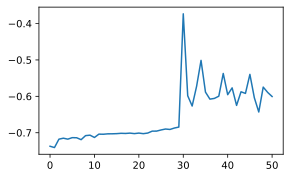

In [59]:
best_loss, best_params = zip(*best_loss_params)
plt.plot(best_loss)

In [60]:
best_best_loss = np.min(best_loss)
best_best_index = np.argmin(best_loss)
approx_ratio = 1/2*(1-best_best_loss)
print('Approx ratio:', approx_ratio)

Approx ratio: 0.8703768051658718


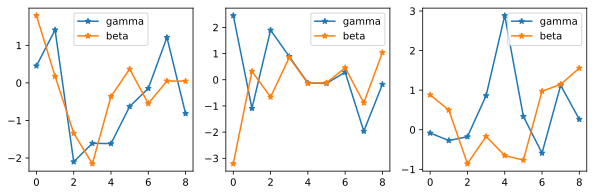

In [61]:
loss_params_sorted = sorted(best_loss_params, key=lambda x: x[0])
plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_gamma_beta(*loss_params_sorted[0][1])
plt.subplot(132)
plot_gamma_beta(*loss_params_sorted[1][1])
plt.subplot(133)
plot_gamma_beta(*loss_params_sorted[2][1])

## Re-start learning

In [63]:
leave_out_num = 30
N = 51 - leave_out_num
leave_out_params = list(list(zip(*loss_params_sorted))[1])[:leave_out_num]  
next_params = leave_out_params + list(zip(np.random.randn(N, p), np.random.randn(N, p)))

In [ ]:
next_best_loss_params = parallel.starmap(partial(optimize_params, steps=30, lr=0.003), next_params)

In [ ]:
best_loss, best_params = zip(*next_best_loss_params)
plt.plot(best_loss)
best_best_loss = np.min(best_loss)
best_best_index = np.argmin(best_loss)
approx_ratio = 1/2*(1-best_best_loss)
print('Approx ratio:', approx_ratio)

In [58]:
best_loss_params = next_best_loss_params

Restart before here

## Continious learning

Restart before here

In [15]:
parallel = JobLib(processes=112//2)

N = 51
leave_out_num = 20
restarts = 30
steps = 80
gamma, beta = np.random.rand(N, p), np.random.rand(N, p)
init_params = zip(gamma, beta)
loss_params_sorted = [(0, x) for x in init_params]

In [ ]:
for i in range(restarts):
    N = 51 - leave_out_num
    leave_out_params = list(list(zip(*loss_params_sorted))[1])[:leave_out_num]  
    next_params = leave_out_params + list(zip(
        np.random.rand(N, p),
        np.random.rand(N, p)
    ))
    best_loss_params = parallel.starmap(partial(
        optimize_params, steps=steps, lr=0.003)
                                        , next_params)
    loss_params_sorted = sorted(best_loss_params, key=lambda x: x[0])
    
    best_best_loss = loss_params_sorted[0][0]
    approx_ratio = 1/2*(1-best_best_loss)
    print(f'[{i}] Approx ratio:', approx_ratio)
    print(f'[{i}] Params:', loss_params_sorted[0][1])

[0] Approx ratio: 0.8444458975913102
[0] Params: [array([0.97836874, 0.96302797, 0.30483525, 0.09813011, 0.3658271 ,
       0.56949087, 0.36633635, 0.03229572, 0.28455606]), array([ 0.05417539,  0.18509255,  0.52313354,  0.36163235,  0.93530316,
        0.87531028,  0.33823047,  0.73499248, -0.04791236])]
[1] Approx ratio: 0.8609830101103801
[1] Params: [array([0.94759103, 0.89673843, 0.31781941, 0.06570616, 0.33756262,
       0.55284176, 0.36426227, 0.02702173, 0.29010159]), array([ 0.21406634,  0.18926904,  0.53568432,  0.31194581,  0.93943569,
        0.84396499,  0.28426961,  0.79470546, -0.05034343])]
[2] Approx ratio: 0.8626276499226581
[2] Params: [array([0.94973952, 0.90024728, 0.33016063, 0.05228032, 0.33099138,
       0.54606845, 0.355811  , 0.02653423, 0.28540197]), array([ 0.21016099,  0.18769374,  0.55087272,  0.2822346 ,  0.93463964,
        0.82072822,  0.26136151,  0.81930439, -0.05116279])]
[3] Approx ratio: 0.8654703663922421
[3] Params: [array([0.05785311, 0.96219317

In [16]:
from cartesian_explorer.parallels import JobLib

parallel = JobLib(processes=112//2)

In [17]:
N = 112*2
gamma, beta = np.random.randn(N, p), np.random.randn(N, p)
pargs = zip(gamma, beta)

In [ ]:
best_loss_params = parallel.starmap(partial(optimize_params, steps=50), pargs)

Restart from here

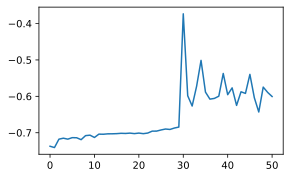

In [59]:
best_loss, best_params = zip(*best_loss_params)
plt.plot(best_loss)

In [60]:
best_best_loss = np.min(best_loss)
best_best_index = np.argmin(best_loss)
approx_ratio = 1/2*(1-best_best_loss)
print('Approx ratio:', approx_ratio)

Approx ratio: 0.8703768051658718


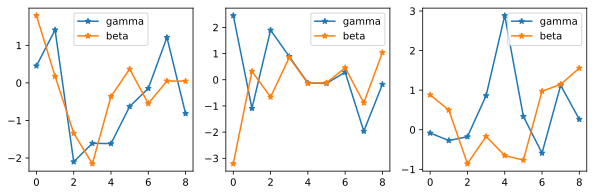

In [61]:
loss_params_sorted = sorted(best_loss_params, key=lambda x: x[0])
plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_gamma_beta(*loss_params_sorted[0][1])
plt.subplot(132)
plot_gamma_beta(*loss_params_sorted[1][1])
plt.subplot(133)
plot_gamma_beta(*loss_params_sorted[2][1])

## Re-start learning

In [36]:
leave_out_num = 30
N = 51 - leave_out_num
leave_out_params = list(list(zip(*loss_params_sorted))[1])[:leave_out_num]  
next_params = leave_out_params + list(zip(np.random.random((N, p)), np.random.random((N, p))))

In [ ]:
next_best_loss_params = parallel.starmap(partial(optimize_params, steps=30, lr=0.003), next_params)

In [ ]:
best_loss, best_params = zip(*next_best_loss_params)
plt.plot(best_loss)
best_best_loss = np.min(best_loss)
best_best_index = np.argmin(best_loss)
approx_ratio = 1/2*(1-best_best_loss)
print('Approx ratio:', approx_ratio)

In [58]:
best_loss_params = next_best_loss_params

## 

### Finish up by further optimizing the best point

In [100]:
gamma, beta = best_params[best_best_index]

In [101]:
gamma, beta

(array([ 0.45032692, -1.59767389, -0.10992576,  1.37776669, -0.68170367,
        -0.97164854,  0.78962364]),
 array([-0.70481029,  1.67401291,  1.15593685,  1.85465617,  0.32534419,
         0.27089758,  0.05440007]))

In [90]:
loss_history, params_history = popt.qaoa_maxcut_torch(B, gamma, beta,
                                                      ordering_algo='tamaki_40',
                                                      edge=(0, 1),
                                                      Opt=torch.optim.Adam,
                                                      opt_kwargs=dict(lr=0.0002),
                                                      steps=20)

Best solution: -0.7149610829891299
Best params: [array([-0.58576837,  1.05404401, -0.64719785, -1.62089253, -0.13675797,
       -0.16263004,  1.31963884]), array([ 0.12868154,  0.13226227, -1.32794239, -0.64621956,  1.38890427,
        0.42095737, -0.95688474])]


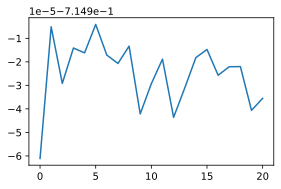

In [91]:
plt.plot(loss_history)
print('Best solution:', np.min(loss_history))
best_ix = np.argmin(loss_history)
best_params = params_history[best_ix]
print('Best params:', best_params)

In [87]:
estimate_cut = 1/2*(B.number_of_edges() - loss_history[best_ix]*B.number_of_edges())
approx_ratio = estimate_cut/B.number_of_edges()
print('Approx ratio:', approx_ratio)

Approx ratio: 0.8574805414945649


## Check the same parameters for random regular graph

Number of edges: 15


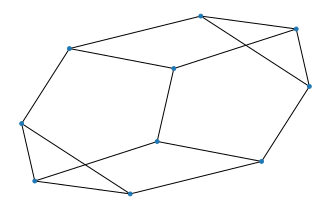

In [17]:
G = qtensor.toolbox.random_graph(nodes=10, degree=3, seed=10)
print('Number of edges:', G.number_of_edges())
nx.draw_kamada_kawai(G, node_size=15)

In [18]:
def maxcut_cost(G, gamma, beta):
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer)
    return sim.energy_expectation(G, gamma, beta)

In [19]:
maxcut_cost(G, *best_params)

array([12.33029447])

In [20]:
loss_history, param_history = popt.qaoa_maxcut_torch(G, gamma, beta, steps=20)

KeyboardInterrupt: 

Best energy: 20.805624


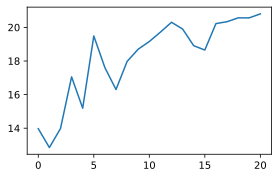

In [15]:
energies = - np.array(loss_history)
print('Best energy:', np.max(energies))
plt.plot(energies)

In [24]:
bound = qtensor.tools.maxcut.spectral_bound(G)
transfer_cost = maxcut_cost(G, *best_params)[0]
approx_ratio_bound = transfer_cost/(bound*G.number_of_edges())
print("Approx ratio bound =", approx_ratio_bound)
print("Approx ratio Bethe =", approx_ratio)


Approx ratio bound = 0.9039485906264829
Approx ratio Bethe = 0.8433088647040107


In [25]:
transfer_cost

12.330294472795362

In [31]:
transfer_cost/(bound*G.number_of_edges())

0.9039485906264829

## Compare for multiple graphs

In [9]:
#export
from cartesian_explorer import Explorer
from cartesian_explorer import caches, parallels

cache = caches.JobLibCache('../../caex_cache/bethe_transfer')
PAR = True
if PAR:
    parallel = parallels.Ray(processes=50)
    ex = Explorer(cache=cache, parallel=parallel)
else:
    ex = Explorer(cache=cache)

2021-03-09 18:30:29,605	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8266


In [10]:
@ex.provider
def graph(N, seed=10):
    return nx.random_regular_graph(d=3, n=N, seed=seed)

In [11]:
@ex.provider
def regular_approximation_bound(graph, p, bethe_params):
    gamma, beta = bethe_params
    bound = qtensor.tools.maxcut.spectral_bound(graph)
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, max_tw=25)
    try:
        transfer_cost = sim.energy_expectation(graph, gamma, beta)
    except Exception as e:
        print(e)
        return None
    approx_ratio_bound = transfer_cost/(bound*graph.number_of_edges())
    return approx_ratio_bound


In [12]:
@ex.provider
def regular_approximation_bound_cache(graph, p, bethe_params_cache, 
                                      ordering_algo='greedy'
                                     ):
    gamma, beta = bethe_params_cache
    bound = qtensor.tools.maxcut.spectral_bound(graph)
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, max_tw=26)
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo)
    sim.optimizer=opt
    try:
        transfer_cost = sim.energy_expectation(graph, gamma, beta)
    except Exception as e:
        print(e)
        return None
    approx_ratio_bound = transfer_cost/(bound*graph.number_of_edges())
    return approx_ratio_bound


In [13]:

@ex.provider
def bethe_approximation_cache(p):
    return qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val']

@ex.provider
def bethe_params_cache(p):
    gammabeta = qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'] 
    gammabeta = np.array(gammabeta)
    gammabeta = gammabeta/np.pi
    gamma, beta = gammabeta[:p], gammabeta[p:]
    assert len(beta)==len(gamma), "Wrong parameters format, possibly unsolved p"
    return tuple(gamma), tuple(beta)
    

In [14]:
@ex.add_function(provides=('bethe_approximation', 'bethe_params'), requires=('p'))
def bethe_params(p, seed=10):
    B = qtensor.toolbox.bethe_graph(p=p, degree=3)
    gamma, beta = 1-np.cos(np.linspace(0,1,p)), 1-np.cos(np.linspace(0,1,p))
    loss_history, params_history = popt.qaoa_maxcut_torch(B, gamma, beta,
                                                          edge=(0, 1),
                                                          Opt=torch.optim.Adam,
                                                          opt_kwargs=dict(lr=0.006),
                                                          steps=200)
    best_ix = np.argmin(loss_history)
    best_loss = loss_history[best_ix]
    best_params = params_history[best_ix]
    estimate_cut = 1/2*(1 - best_loss)
    approx_ratio = estimate_cut
    return approx_ratio, (tuple(best_params[0]), tuple(best_params[1]))

In [25]:
def plot_with_minmax(x, line, **kwargs):
    line=line.astype(np.float64)
    median = np.nanmedian(line, axis=-1)
    plt.plot(x, median, **kwargs)
    fill_kwargs = dict(
        alpha=0.1, color=kwargs.get('color')
    )
    plt.fill_between(x, np.nanmin(line, axis=-1), np.nanmax(line, axis=-1), **fill_kwargs)

/home/danlkv/.local/bin/lib/python3.8/site-packages/cartesian_explorer/ExplorerBasic.py:167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(result_lin).reshape(result_shape)
/home/danlkv/.local/bin/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-25-8d5754475ee6>:8: RuntimeWarning: All-NaN slice encountered
  plt.fill_between(x, np.nanmin(line, axis=-1), np.nanmax(line, axis=-1), **fill_kwargs)


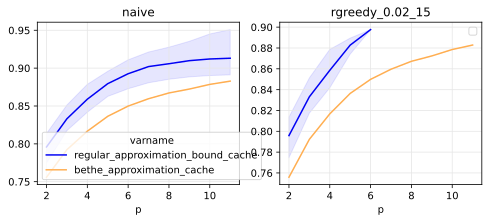

In [28]:
f = ex.plot(ex.get_variable,
            plot_func=plot_with_minmax,
            distribution_var='seed',
            ordering_algo=['naive', 'rgreedy_0.02_15'],
            varname=('regular_approximation_bound_cache', 'bethe_approximation_cache'),
            p=[2,3,4,5,6,7,8,9,10,11],
            seed=range(30),
            N=[18],
)

plt.legend('')
plt.savefig('../../../data/figures/bethe_approx_18.pdf')

In [27]:
f = ex.plot(ex.get_variable,
    distribution_var='seed',
    ordering_algo=['naive', 'rgreedy_0.02_50'],
    varname=('regular_approximation_bound_cache', 'bethe_approximation_cache'),
    p=[2,3,4,5,6,7,8,9],
    seed=[10, 11, 12, 13, 14],
    N=[100],
)
plt.legend('')
#plt.savefig('/tmp/plot_approx.png')

KeyboardInterrupt: 

In [115]:
f = ex.plot2d(ex.get_variable,
          p=[2,3,4,5,6,7],
          varname=('bethe_approximation', 'regular_approximation_bound', 'bethe_approximation_cache'),
          N=range(6, 22, 2),
          seed=[10]
         )
plt.savefig('/tmp/plot_approx.png')

KeyboardInterrupt: 

In [154]:
p = 3
gb = bethe_params_cache(p)
gamma, beta = gb
gamma, beta

((0.14625538825784332, 0.35087973860935995, 0.42500476233846124),
 (0.932857136289293, 0.19381151457591544, -0.12706819386164936))

In [153]:
maxcut_cost(G, -np.array(beta), -np.array(gamma))

array([7.0612915])

In [124]:
G.number_of_edges

15

In [26]:
bethe_approximation_cache(5)

0.8363793482380077

In [28]:
bethe_approximation_cache(7)

-10

P = 5: 0.8363808251293595

P = 6: 0.8498971345568782

P = 7: 0.8597842270056604

In [7]:
data_vw = """
P = 1: 0.6924501

P = 2: 0.7559065

P = 3: 0.7923981

P = 4: 0.8168765648464446

P = 5: 0.8363808251293595

P = 6: 0.8498971345568782

P = 7: 0.8597842270056604"""

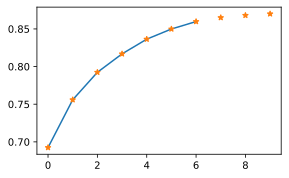

In [13]:
appx_vw = [
   float(x.split(':')[1]) for
    x in data_vw.split('\n')
    if ':' in x
]

plt.plot(appx_vw)
plt.plot(appx_vw+[0.865,0.868,0.87], '*')

In [ ]:
1/np.s